In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pylab import rcParams

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [267]:
rcParams['figure.figsize'] = 15, 6

In [268]:
path_matlab = "../../data/series/series_matlab.csv"
path_fires = "../../data/series/series_fires_acre.csv"

series_matlab = pd.read_csv(path_matlab)
series_fires = pd.read_csv(path_fires, encoding='ISO-8859-1')

In [269]:
series_matlab

,month,matlab
0,2009-01-31,19
1,2009-02-28,27
2,2009-03-31,24
3,2009-04-30,32
4,2009-05-31,42
...,...,...
127,2019-08-31,371
128,2019-09-30,362
129,2019-10-31,523
130,2019-11-30,479


In [270]:
series_matlab['month'] = pd.to_datetime(series_matlab['month'])

In [271]:
series_matlab = series_matlab.set_index('month')

<Axes: xlabel='month'>

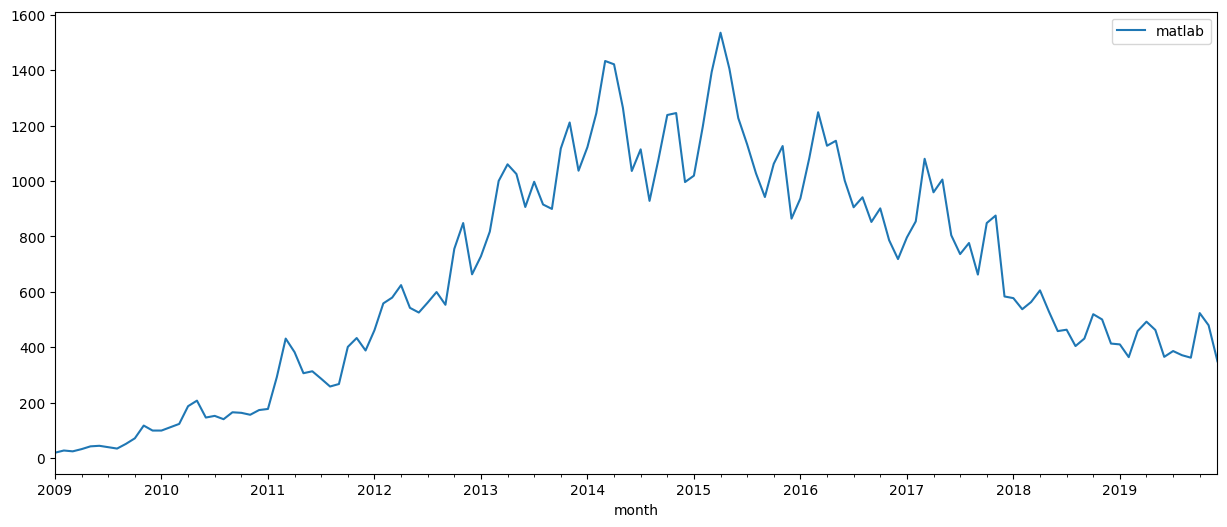

In [272]:
series_matlab.plot()

In [273]:
train_matlab, val_matlab, test_matlab = series_matlab.loc['2009':'2016'], series_matlab.loc['2017'], series_matlab.loc['2018':'2019']

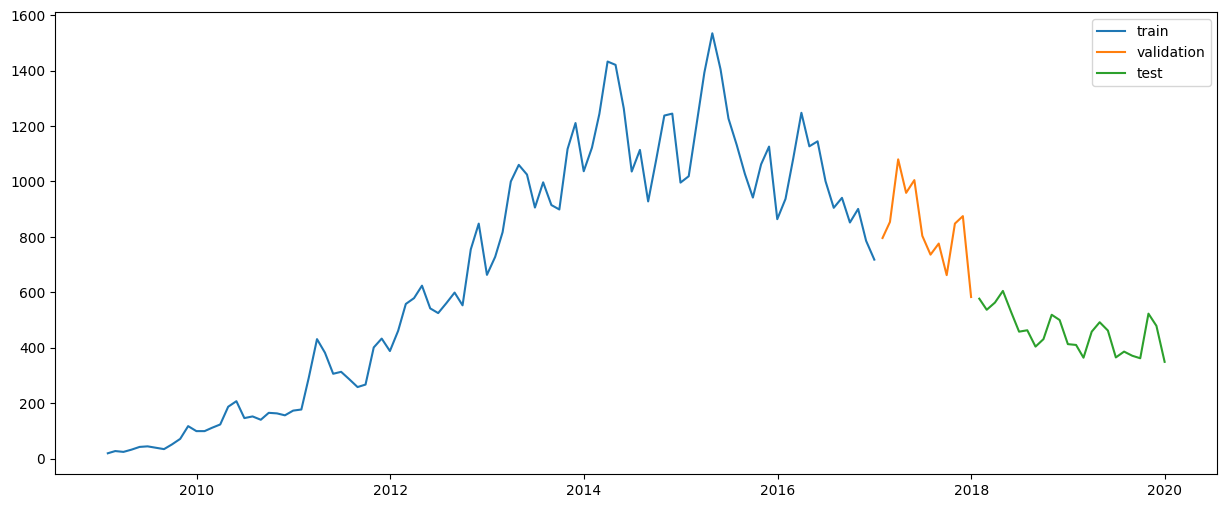

In [274]:
plt.plot(train_matlab, label = 'train')
plt.plot(val_matlab, label = 'validation')
plt.plot(test_matlab, label = 'test')
plt.legend(loc = 'best')
plt.show()

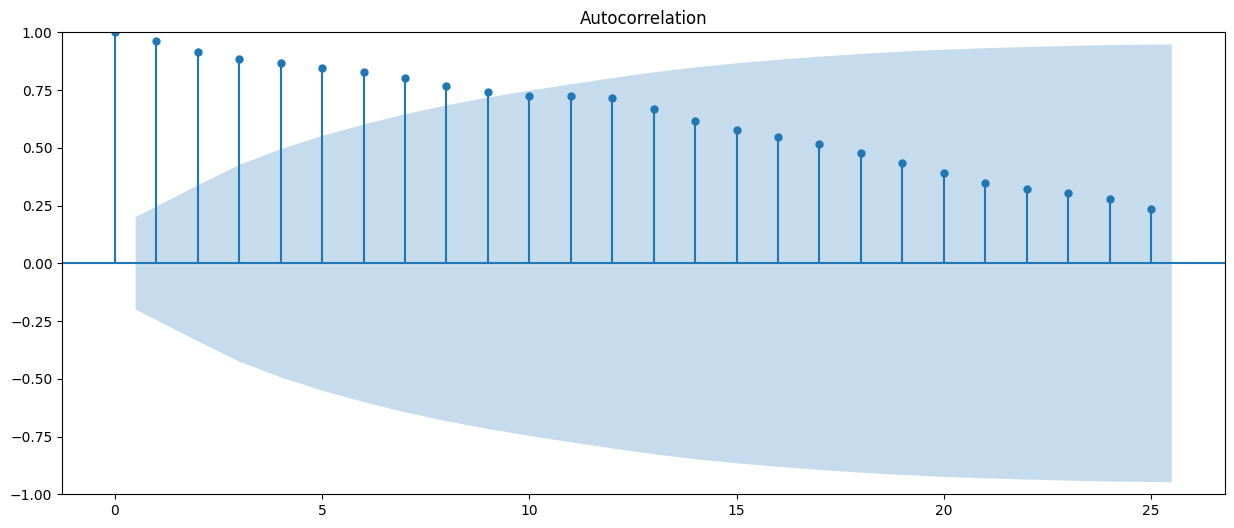

In [275]:
sm.graphics.tsa.plot_acf(train_matlab, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


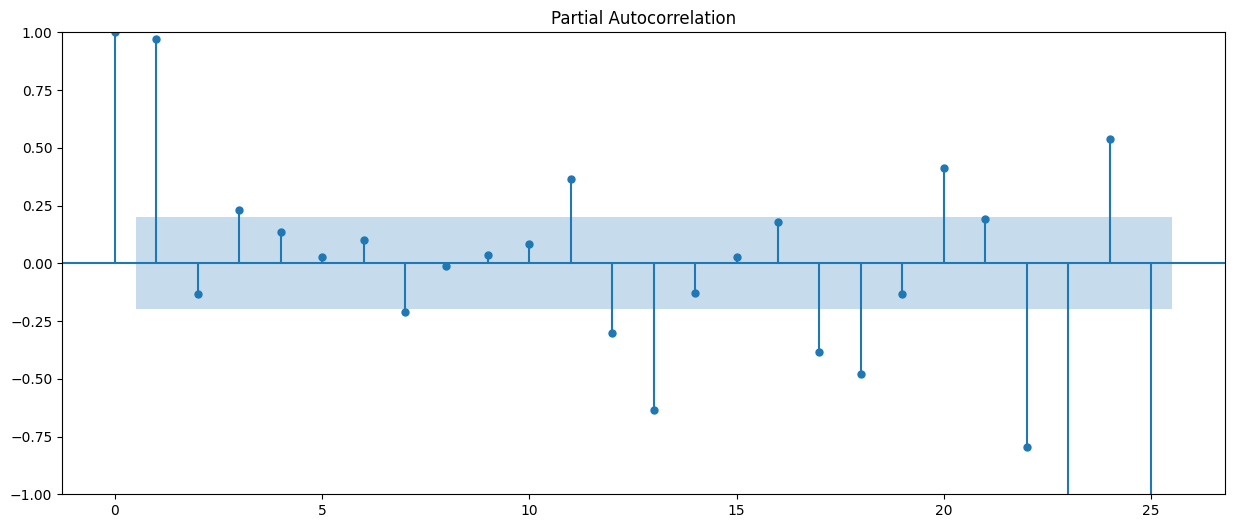

In [276]:
fig = sm.graphics.tsa.plot_pacf(train_matlab, lags=25)
plt.show()

In [277]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [278]:
train_windows = create_sliding_windows(train_matlab, 9)
val_windows = create_sliding_windows(val_matlab, 9)
test_windows = create_sliding_windows(test_matlab, 9)

In [279]:
train_windows.shape

(87, 10)

In [280]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [281]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]


best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m)
      modelo.fit(X_train, y_train)
      prev_val = modelo.predict(X_val)

      mse = MSE(y_val, prev_val)
      if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s
        best_depth = m

In [282]:
(best_criterion, best_splitter, best_depth, best_mse)

('poisson', 'random', 40, 5259.333333333333)

In [283]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [284]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

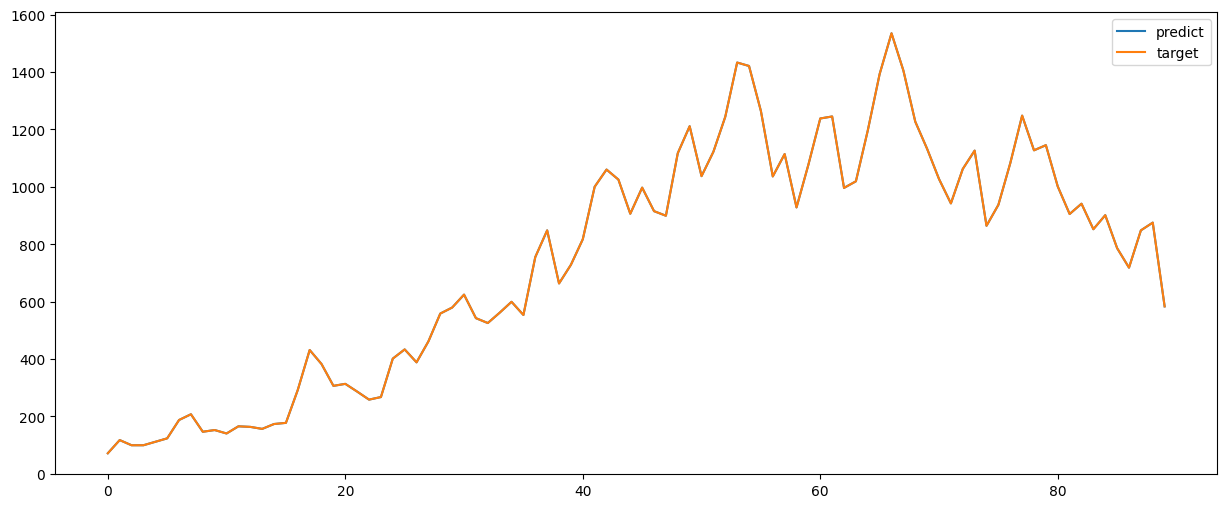

In [285]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [286]:
MSE(y_train_full, prev_train)

0.0

In [287]:
prev_test = modelo.predict(X_test)

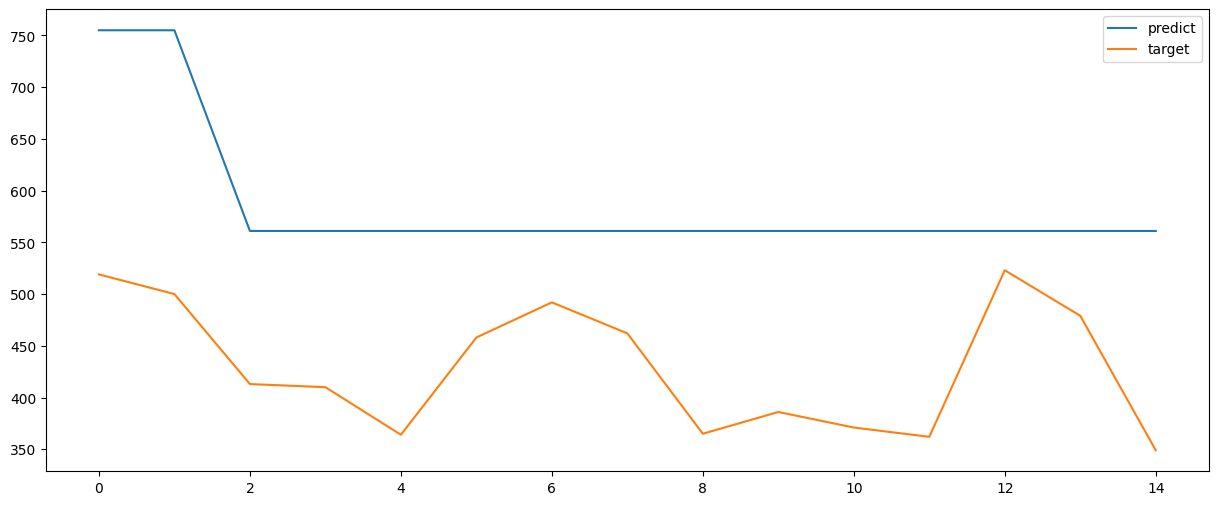

In [288]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [289]:
MSE(y_test, prev_test)

28484.0

### Tuning Hyperparameters

In [367]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
min_samples_split = [2,3,4,5,6,7,8,9,10,]
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005]

best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_ccp_alpha = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      for mss in min_samples_split:
        for msl in min_samples_leaf:
          for ccp_alpha in ccp_alphas:
            modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
            modelo.fit(X_train, y_train)
            prev_val = modelo.predict(X_val)

            mse = MSE(y_val, prev_val)
            if mse < best_mse:
              best_mse = mse
              best_criterion = c
              best_splitter = s
              best_depth = m
              best_min_samples_split = mss
              best_min_samples_leaf = msl
              best_ccp_alpha = ccp_alpha


In [368]:
best_mse

215.0

In [369]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('absolute_error', 'random', 40, 5, 5, 0.003, 215.0)

In [370]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [371]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

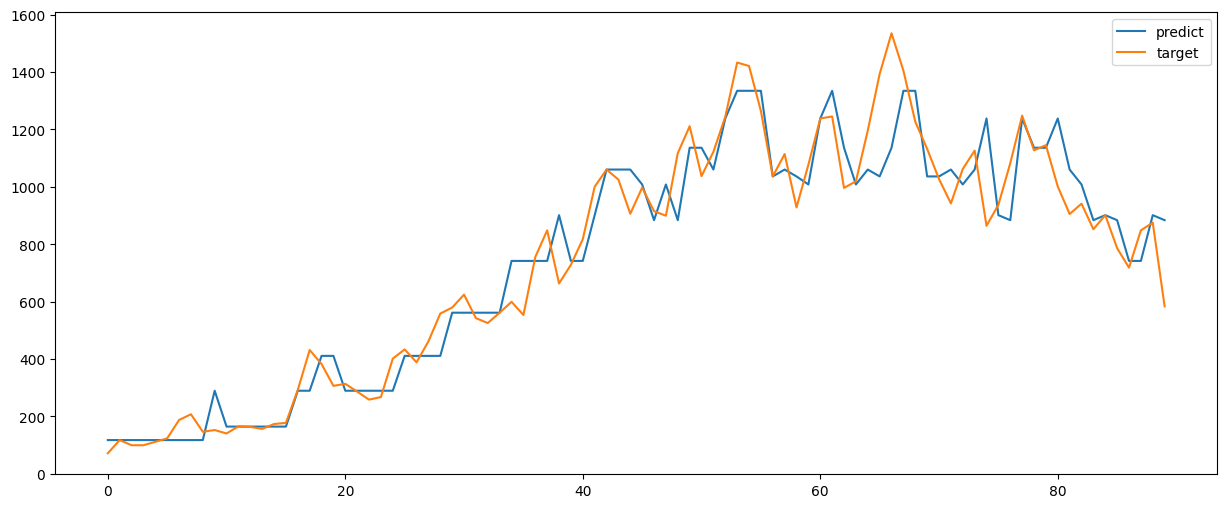

In [372]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [373]:
MSE(y_train_full, prev_train)

12953.572222222223

In [374]:
prev_test = modelo.predict(X_test)

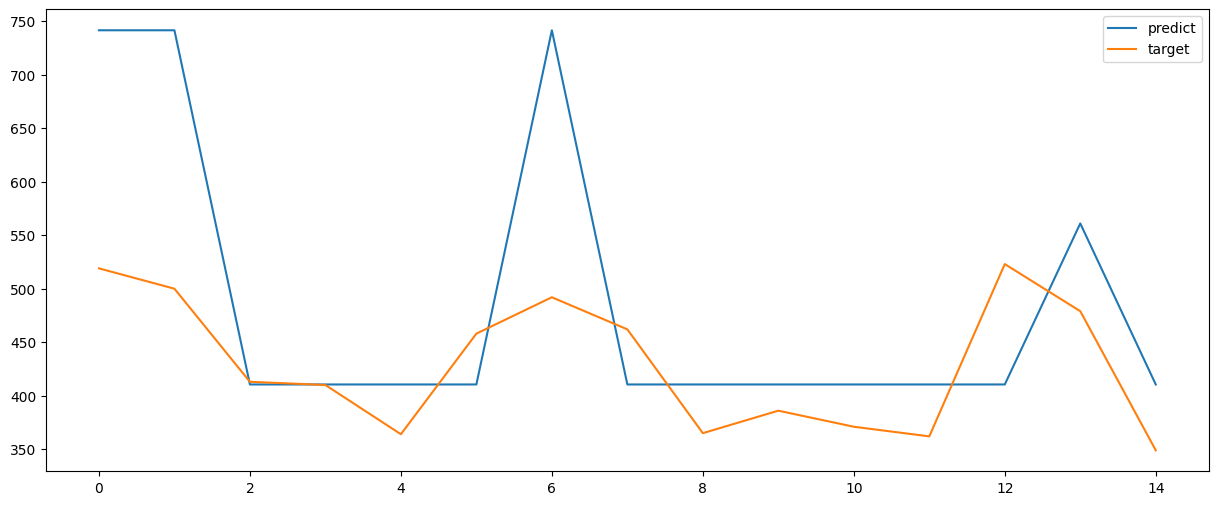

In [375]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [376]:
MSE(y_test, prev_test)

13793.433333333332

## MLPRegressor

In [377]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\App

identity sgd constant


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


identity sgd invscaling


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


identity sgd adaptive


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perce

In [378]:
(best_activation, best_solver, best_learning_rate, best_mse)

('relu', 'lbfgs', 'invscaling', 10436.222761840283)

In [379]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [380]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


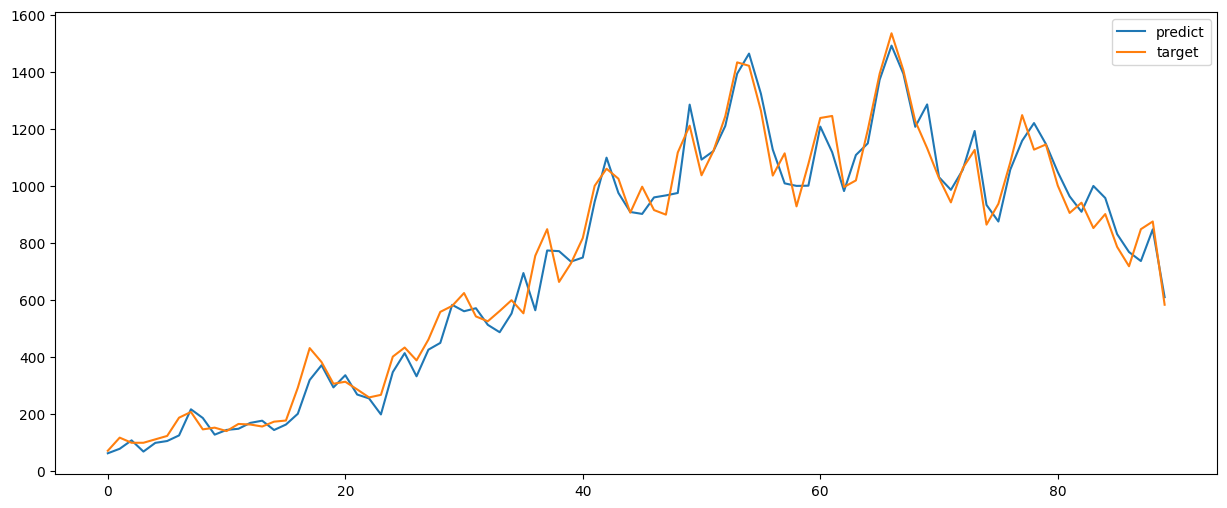

In [381]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [382]:
MSE(y_train_full, prev_train)

4163.582733523379

In [383]:
prev_test = modelo.predict(X_test)

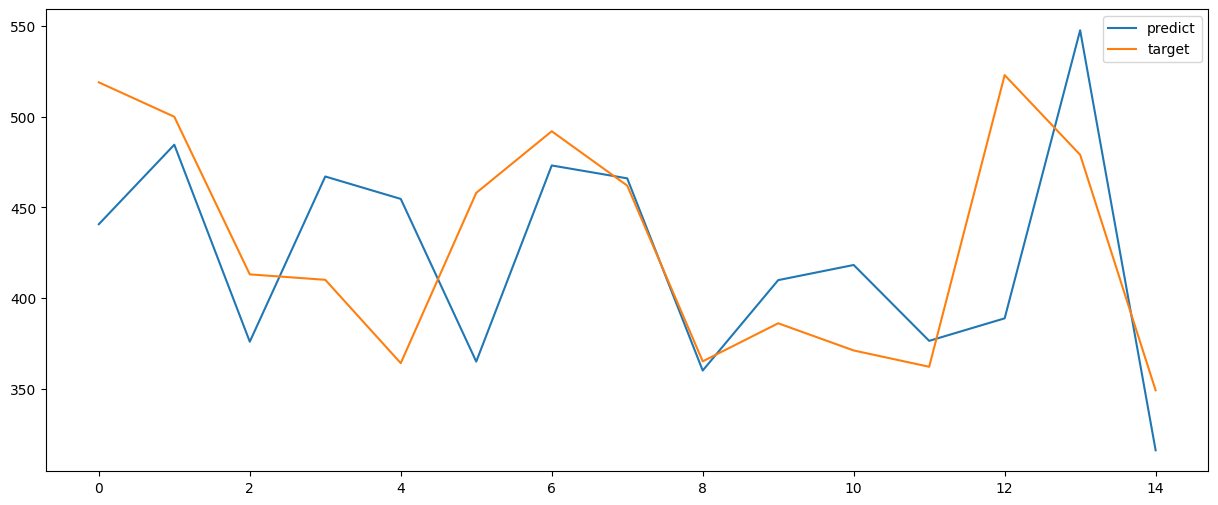

In [384]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [385]:
MSE(y_test, prev_test)

3676.1858495059328

## KNeighborsRegressor

In [386]:
neighbors = [1,2,3,4,5,10,20,30,40,50]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [1,5,10,15,20,25,30,35,40,45,50]

best_mse = np.inf
best_neighbors = None
best_weights = None
best_algorithm = None
best_leaf_size = None

for n in neighbors:
  for w in weights:
    for a in algorithm:
        for l in leaf_size:
          modelo = KNeighborsRegressor(n_neighbors=n, weights=w, algorithm=a, leaf_size=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)

          mse = MSE(y_val, prev_val)
          if mse < best_mse:
              best_mse = mse
              best_neighbors = n
              best_weights = w
              best_algorithm = a
              best_leaf_size = l

In [387]:
(best_neighbors, best_weights, best_algorithm, best_leaf_size, best_mse)

(4, 'distance', 'auto', 1, 53876.763932957)

In [388]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [389]:
modelo = KNeighborsRegressor(n_neighbors=best_neighbors, weights=best_weights, algorithm=best_algorithm, leaf_size=best_leaf_size)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

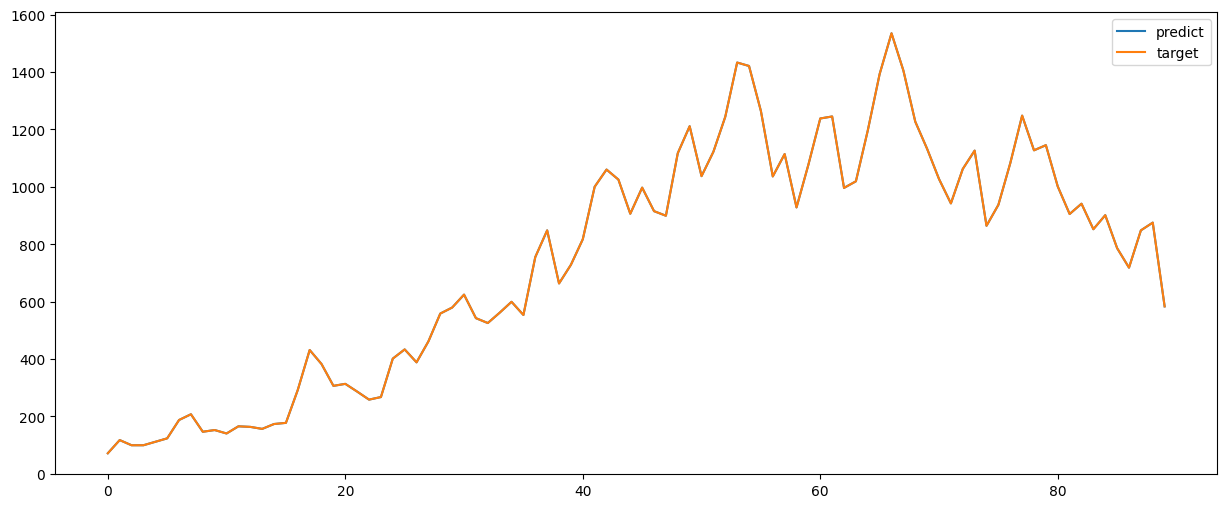

In [390]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [391]:
MSE(y_train_full, prev_train)

0.0

In [392]:
prev_test = modelo.predict(X_test)

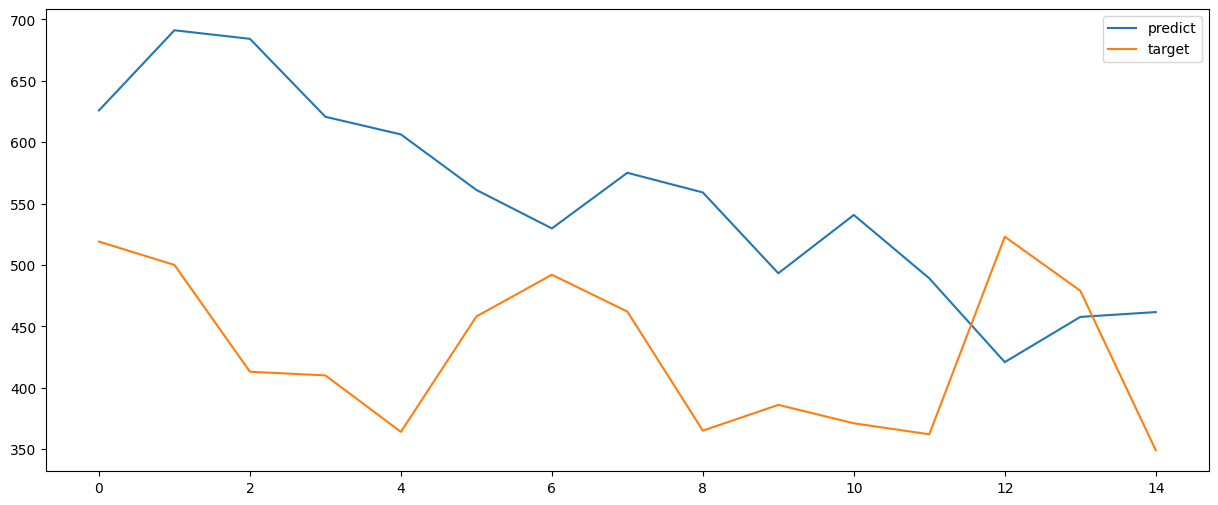

In [393]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [394]:
MSE(y_test, prev_test)

24470.5001564858